### $$\dot{m} = k_{leak} + k_{tx}\frac{p^n}{K^n + p^n} - (\gamma_m+\mu)m$$
### $$\dot{p} =  k_{tl}m - (\gamma_p + \mu)p$$

#### Hyperparameters
##### $k_{tx} [mRNA · time^{−1}]$ — transcription rate.
##### $k_{tl} [(protein).mRNA · time^{−1}]$ - translation rate.
##### $γm[time−1]$ — mRNA decay rate
##### $γp[time−1]$ — protein decay rate
##### $μ [time−1]$ — growth/dilution rate (set 0 for non-growing cells or include to see how growth throttles levels)

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import mplhelv

In [2]:
def genex(t, mp, params):
    kleak, ktx, gammam, mu, ktl, gammap, K, n = params
    m, p = mp
    mdot = kleak + ktx*(p**n)/(K**n + p**n) - (gammam + mu)*m
    pdot = ktl*m - (gammap + mu)*p
    return [mdot, pdot]

In [3]:
time = (0, 24)

K=250 #(half-activation mid-range)
n=2
ktx=5
kleak = 0.2
gammam=1.386
ktl=60
gammap=0.139
mu=0.03
m0=0 
p0=0 # 600

### Time courses with two ICs: $p_0 = 0$

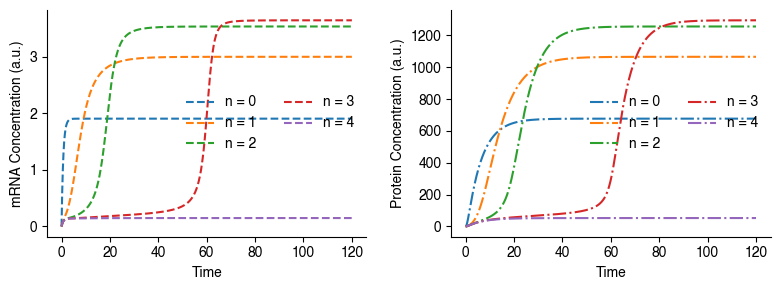

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for n in range(5):
    params = (kleak, ktx, gammam, mu, ktl, gammap, K, n)
    time = (0, 120)
    sol = solve_ivp(genex, time, [m0, p0], args=(params,),
                method='RK45', dense_output=True,
                rtol=1e-6, atol=1e-9, max_step=np.inf)
    t = np.linspace(*time, 4000)
    mdot, pdot = sol.sol(t)
    axs[0].plot(t, mdot, ls='--', label=f'n = {n}')
    axs[1].plot(t, pdot, ls='-.', label=f'n = {n}')
    # p_ss = p_star(K, n)
    # m_ss = (gammap+mu)/ktl * p_ss
    # axs[0].axhline(m_ss, ls='--', lw=1, alpha=0.3)
    # axs[1].axhline(p_ss, ls='--', lw=1, alpha=0.3)
    axs[1].set_ylabel("Protein Concentration (a.u.)")
    axs[0].set_ylabel("mRNA Concentration (a.u.)")
    # axs[0].set_xlim(0, 24)
    # axs[1].set_xlim(0, 24)
for ax in axs.flatten():
    ax.set_xlabel("Time")
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, ncol=2)
fig.tight_layout()

### Time courses with two ICs: $p_0 = 600$

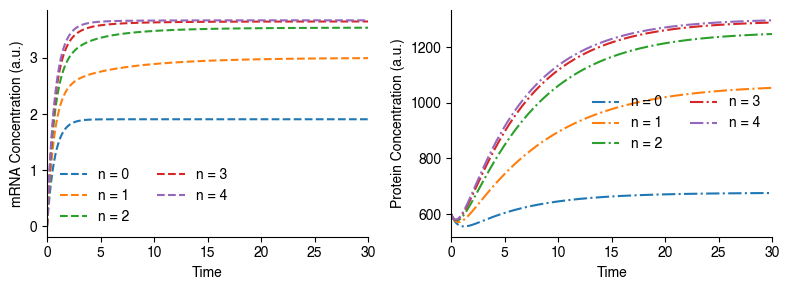

In [5]:
p0 = 600
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for n in range(5):
    params = (kleak, ktx, gammam, mu, ktl, gammap, K, n)
    time = (0, 30)
    sol = solve_ivp(genex, time, [m0, p0], args=(params,),
                method='RK45', dense_output=True,
                rtol=1e-6, atol=1e-9, max_step=np.inf)
    t = np.linspace(*time, 4000)
    mdot, pdot = sol.sol(t)
    axs[0].plot(t, mdot, ls='--', label=f'n = {n}')
    axs[1].plot(t, pdot, ls='-.', label=f'n = {n}')
    # p_ss = p_star(K, n)
    # m_ss = (gammap+mu)/ktl * p_ss
    # axs[0].axhline(m_ss, ls='--', lw=1, alpha=0.3)
    # axs[1].axhline(p_ss, ls='--', lw=1, alpha=0.3)
    axs[1].set_ylabel("Protein Concentration (a.u.)")
    axs[0].set_ylabel("mRNA Concentration (a.u.)")
    axs[0].set_xlim(0, 30)
    axs[1].set_xlim(0, 30)
for ax in axs.flatten():
    ax.set_xlabel("Time")
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, ncol=2)
fig.tight_layout()

### Phase plane $(m,p)$ with nullclines

In [6]:
G = (ktl)/((gammam+mu)*(gammap+mu))
def p_star(p):
    return p - G*(kleak + (ktx*p**n)/(K**n + p**n))

In [7]:
m_min = 0
p_min = 0
m_max = 0.5
p_max = 100

m_line = np.linspace(m_min, m_max, 500)
p_line = np.linspace(p_min, p_max, 500)

In [8]:
m_null = (kleak + ktx*(p_line**n)/(K**n + p_line**n))/(gammam + mu)
p_null = ktl*m_line/(gammap + mu)

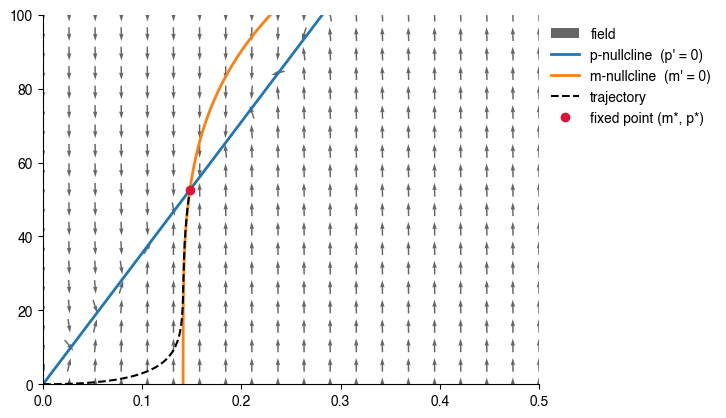

In [9]:
m_grid, p_grid = np.meshgrid(np.linspace(m_min, m_max, 20), np.linspace(p_min, p_max, 20))

m_vf = kleak + ktx*(p_grid**n)/(K**n + p_grid**n) - (gammam + mu)*m_grid
p_vf = ktl*m_grid - (gammap + mu)*p_grid
speed = np.hypot(m_vf, p_vf)
speed[speed == 0] = 1.0
m_vf /= speed
p_vf /= speed

m0 = 0
p0 = 0
params = (kleak, ktx, gammam, mu, ktl, gammap, K, n)
time = (0, 120)
sol = solve_ivp(genex, time, [m0, p0], args=(params,),
            method='RK45', dense_output=True,
            rtol=1e-6, atol=1e-9, max_step=np.inf)
t = np.linspace(*time, 4000)
mdot, pdot = sol.sol(t)

p_s = brentq(p_star, 0, 3000)
m_s = ((gammap + mu) / ktl) * p_s

fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.quiver(m_grid, p_grid, m_vf, p_vf, pivot='mid', linewidth=0.5, alpha=0.6, label='field')
ax.plot(m_line, p_null,  lw=2, label="p-nullcline  (p' = 0)")
ax.plot(m_null, p_line,  lw=2, label="m-nullcline  (m' = 0)")
ax.plot(mdot, pdot, ls='--', c='k', label='trajectory')
ax.plot(m_s, p_s, 'o', color='crimson', label="fixed point (m*, p*)")
ax.set_xlim(0, m_max)
ax.set_ylim(0, p_max)
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon = False, bbox_to_anchor=(1, 1))

In [10]:
def p_star(K, n):
    f = lambda p: p - G*(kleak + (ktx*p**n)/(K**n + p**n))
    return brentq(f, 0.0, 5000)           # bracket works: f(0)<0, f(G)>0

In [11]:
def genex(t, mp, params):
    kleak, ktx, gammam, mu, ktl, gammap, Kfunc, n = params
    K = Kfunc(t)
    m, p = mp
    mdot = kleak + ktx*(p**n)/(K**n + p**n) - (gammam + mu)*m
    pdot = ktl*m - (gammap + mu)*p
    return [mdot, pdot]

K_lo = 1
K_hi = 200
T = 200
def K_up(t):   
    return K_lo + (K_hi - K_lo)*t/T
def K_down(t): 
    return K_hi - (K_hi - K_lo)*t/T

(0.0, 1368.9701250693547)

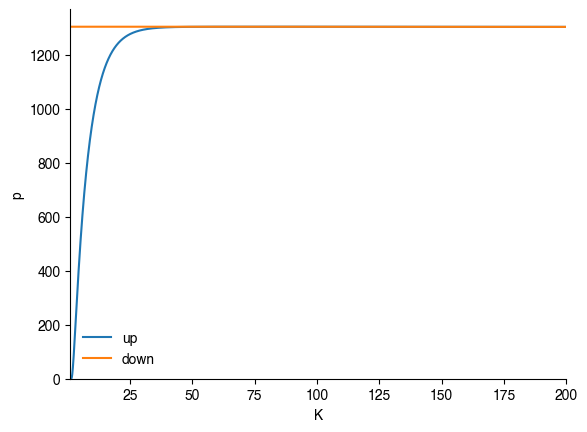

In [22]:
fig, axs = plt.subplots()
gammap=0.139
params = (kleak, ktx, gammam, mu, ktl, gammap, K_up, n)
time = (0, T)
t = np.linspace(*time, 4000)
sol_up = solve_ivp(genex, time, [m0, p0], args=(params,),
            method='RK45', t_eval = t, 
                   rtol=1e-6, atol=1e-9, max_step=np.inf)

_, pup = sol_up.y

Ku = K_up(t)


params = (kleak, ktx, gammam, mu, ktl, gammap, K_down, n)
time = (0, T)
sol = solve_ivp(genex, time, y0=sol_up.y[:, -1], args=(params,),
            method='RK45', t_eval = t,
            rtol=1e-6, atol=1e-9, max_step=np.inf)
# t = np.linspace(*time, 4000)
_, pdown = sol.y

Kd = K_down(t)
axs.plot(Ku, pup, label='up')
axs.plot(Kd, pdown, label='down')

axs.set_xlabel('K'); 
axs.set_ylabel('p'); 
axs.legend(frameon=False)
axs.spines[["top", "right"]].set_visible(False)
axs.set_xlim(K_lo, K_hi)
axs.set_ylim(0, None)
# plt.show()
# axs[1].plot(t, pdot, ls='-.', label=f'n = {n}')

In [38]:
def p_star(p, G, K, n):
    return p - G*(kleak + (ktx*p**n)/(K**n + p**n))

2


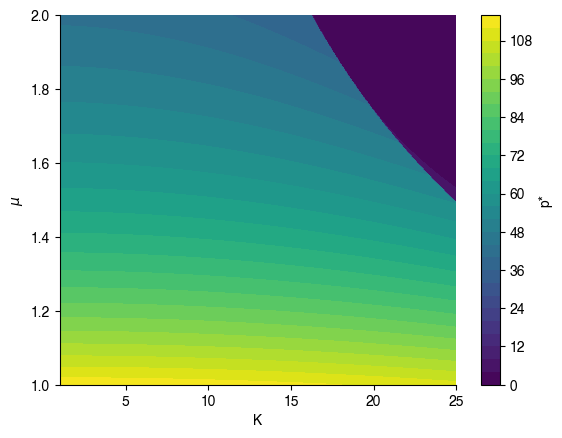

In [44]:
n = 2
fig, axs = plt.subplots()
mu_min = 1
mu_max = 2
K_min = 1
K_max = 25
K_line = np.linspace(K_min, K_max, 400)
mu_line = np.linspace(mu_min, mu_max, 400)
p_sweep = []
for mu in mu_line:
    p_stars = []
    G = (ktl)/((gammam+mu)*(gammap+mu))
    for K in K_line:
        p_star_s = brentq(p_star, 0, 3000, args=(G, K, n))
        p_stars.append(p_star_s)
    p_sweep.append(p_stars)
p_sweep = np.array(p_sweep)
print(p_sweep.ndim)
cs = axs.contourf(K_line, mu_line, p_sweep, levels=30)
fig.colorbar(cs, ax=axs, label='p*')
axs.set_xlabel("K")
axs.set_ylabel(r"$\mu$")
# axs.set_xscale('log')  # optional
axs.spines[["top","right"]].set_visible(False)